In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import wilcoxon 
from Bio.PDB import *
import os

from pylab import rcParams
from scipy.stats import chi2_contingency

# modules and functions

def is_float(elem):
    try:
        elem = float(elem)
        out = True
    except:
        elem = elem
        out = False
    return out
    

def calc_U(one, two):
    try:
        scipy_U = sp.stats.mannwhitneyu(one, two, alternative="two-sided", use_continuity=False)
        # Formula for the relation between AUC and the U statistic
        AUC = scipy_U.statistic/ (len(one)*len(two))
        pval = scipy_U.pvalue
        if AUC < 0.5:
            AUC = 1-AUC
            
        return round(AUC,3), pval
    except:
        return [np.nan, np.nan]

colormap = {'A':'#B8321A', 'C':'#44781E',
            'Compensator':"#4F651D", 'ExplicitControl':"#2F638F", 'Background':"#E5BF86",
           'GeneralControl':"#565052",'Wonder':"#C582B2", 'no_type':"#E5BF86",
           'Not compensated':'#2F414B','Compensated':'#AD6B17',
           'Not compensator':'#7C6C65',
           'Surface':"#DD3C51", 'Core':"#313657", 'PPI':"#1F6683", 
           
           'Protein interaction':"#1F6683", 
           'ligand interaction':'#B09B37'}




three2one = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}





def plot_hist(hue_list, data, col_hue, col_data, mode,figsize):
    # hue_list - list with hues (different hists)
    # data - name of df
    # col_hue - name of column where separate by hue
    # col_data - name of column, where to find data
    # mode - 'wilcoxon' (paired) or 'mann' (independent) samples , 'no' - without p-val
    
    text = []
    plt.figure(figsize=figsize)
    
    for elem in hue_list:
        one = data[col_data][data[col_hue] == elem]
        sns.kdeplot(x = one, label=elem, color= colormap[elem],fill=True,
                   bw_adjust = 3)
        plt.axvline(x=np.median(one), color = colormap[elem])
        text.append(elem+' N=' + str(len(one)) + ' median=' + 
                    str(round(np.nanmedian(one),2))+'\n')
    
    plt.xlabel(col_data)
        
    if mode == 'wilcoxon':
        p_val = wilcoxon(data[col_data][data[col_hue] == hue_list[0]],
                        data[col_data][data[col_hue] == hue_list[1]])[1]
        text.append('p-value: '+str(round(p_val,5)))
        
    if mode == 'mann':
        p_val = calc_U(data[col_data][data[col_hue] == hue_list[0]],
                        data[col_data][data[col_hue] == hue_list[1]])[1]
        text.append('p-value: '+"{:6.3e}".format(p_val))
        
    
    plt.title(' '.join(text))   
    plt.legend()
    return plt
    #plt.show()



def plot_hist_bar(hue_list, data, col_hue, col_data, mode,figsize,bins, fill=False):
    # hue_list - list with hues (different hists)
    # data - name of df
    # col_hue - name of column where separate by hue
    # col_data - name of column, where to find data
    # mode - 'wilcoxon' (paired) or 'mann' (independent) samples , 'no' - without p-val
    data = data[data[col_hue].isin(hue_list)]
    text = []
    plt.figure(figsize=figsize)
   
    for elem in hue_list:
        one = data[col_data][data[col_hue] == elem]
        
        plt.axvline(x=np.median(one), color = colormap[elem])
        text.append(elem+' N=' + str(len(one)) + ' median=' + 
                    str(round(np.nanmedian(one),2))+'\n')
                    
    
    sns.histplot(data = data, x=col_data, hue=col_hue, palette = colormap,
                 common_norm=False,stat="density",bins=bins,element='step',fill=fill,
                )
    
    
    
    
    plt.xlabel(col_data)
        
    if mode == 'wilcoxon':
        p_val = wilcoxon(data[col_data][data[col_hue] == hue_list[0]],
                        data[col_data][data[col_hue] == hue_list[1]])[1]
        text.append('p-value: '+str(round(p_val,5)))
        
    if mode == 'mann':
        p_val = calc_U(data[col_data][data[col_hue] == hue_list[0]],
                        data[col_data][data[col_hue] == hue_list[1]])[1]
        text.append('p-value: '+"{:6.3e}".format(p_val))
        
    
    plt.title(' '.join(text))   
    #plt.legend()
    return plt
    #plt.show()




def plot_many_hists(hue_list, data,figure_list, col_figure, mode, 
                   figsize):
    # hue_list - list with colnames for hues
    # data - name of df
    # figure_list - list of hues (for different figures)
    # col_figure - name of column where separate by figs
    # mode - 'wilcoxon' (paired) or 'mann' (independent) samples , 'no' - without p-val
    n_rows = len(figure_list)//2
    if len(figure_list)%2 != 0:
        n_rows += 1
    i = 0
    fig, axs = plt.subplots(n_rows,2,figsize=figsize)
    for elem in figure_list:
        i1 = i//2
        i2 = i%2
        i+=1
        
        one = data[data[col_figure] == elem][hue_list[0]]
        two = data[data[col_figure] == elem][hue_list[1]]
        one_label = 'A' #A
        two_label = 'C' #C
        #sns.distplot(ax = axs[i1, i2], a=one, bins=10, label=one_label, hist=True,
                    # color=colormap[one_label])
        
        sns.kdeplot(ax = axs[i1, i2], x = one, label=one_label, 
                    color= colormap[one_label],fill=True, bw_adjust = 3)
        
        sns.kdeplot(ax = axs[i1, i2], x = two, label=two_label, 
                    color= colormap[two_label],fill=True, bw_adjust = 3)
        
        # Plot median
        axs[i1, i2].axvline(x=np.nanmedian(one), color = colormap[one_label])
        axs[i1, i2].axvline(x=np.nanmedian(two),color = colormap[two_label])
        one_text = one_label + ' N=' + str(len(one)) + ' median=' + str(round(np.nanmedian(one),2))
        two_text = two_label + ' N=' + str(len(two)) + ' median=' + str(round(np.nanmedian(two),2))
        
        
        if mode == 'wilcoxon':
            p_val = wilcoxon(one,two)[1]
            
        if mode == 'mann':
            p_val = calc_U(one,two)[1]
       
        
        
        axs[i1, i2].set_title(elem+'\n'+one_text + '\n' + two_text+'\n p-val '+
                             "{:6.3e}".format(p_val))
        #axs[i1, i2].set_xlabel(col_figure)
        axs[i1, i2].legend()

    fig.tight_layout(pad=3.0)
    return plt




def rename_bad(elem):
    if elem == 'Compensator':
        return 'Compensated'
    else:
        return 'Not compensated'
    
def rename_neutral(elem):
    if elem != 'Compensator':
        return 'Not compensator'
    else:
        return 'Compensator'
    

In [18]:
import sys
sys.path.append('../')
import pics_module as pics

In [13]:
compeletename = '/Users/azbukinanadezda/Google Диск/Курсач 2021/' 

# import data

In [198]:
df = pd.read_csv('../../CPD_data_12_04_21_for_VER_ddG.tsv.gz',sep='\t')

for elem in df.columns:
    df = df.rename(columns={elem:elem.replace('.','_')})
'''    
df = df.drop_duplicates(subset=['#Pair_Type', 'Dataset', 'Uniprot_AC', 
                               'Pos_A', 'A1', 'A2', 'Score_A',
       'Pos_C', 'C1', 'C2', 'Score_C', 'Score_AC', 'PMD_Phen', 'Effect_A',
       'Effect_C', 'Effect_AC', 'Max_PDB_ID_A', 'Max_Chain_A',
       'Max_Residue-ID_A', 'Max_PDB_AA_A', 'Max_Sequence_identity_A',
       'Max_Coverage_A', 'Max_Resolution_A', 'Max_PDB_ID_C', 'Max_Chain_C',
       'Max_Residue-ID_C', 'Max_PDB_AA_C', 'Max_Sequence_identity_C',
       'Max_Coverage_C', 'Max_Resolution_C', 'Max_Dist_ca', 'Max_Dist_closest',
       ])
df.Dataset.value_counts()
'''

"    \ndf = df.drop_duplicates(subset=['#Pair_Type', 'Dataset', 'Uniprot_AC', \n                               'Pos_A', 'A1', 'A2', 'Score_A',\n       'Pos_C', 'C1', 'C2', 'Score_C', 'Score_AC', 'PMD_Phen', 'Effect_A',\n       'Effect_C', 'Effect_AC', 'Max_PDB_ID_A', 'Max_Chain_A',\n       'Max_Residue-ID_A', 'Max_PDB_AA_A', 'Max_Sequence_identity_A',\n       'Max_Coverage_A', 'Max_Resolution_A', 'Max_PDB_ID_C', 'Max_Chain_C',\n       'Max_Residue-ID_C', 'Max_PDB_AA_C', 'Max_Sequence_identity_C',\n       'Max_Coverage_C', 'Max_Resolution_C', 'Max_Dist_ca', 'Max_Dist_closest',\n       ])\ndf.Dataset.value_counts()\n"

In [199]:
len(df[(df['Max_PDB_ID_A']==df['Max_PDB_ID_C'])&(df['Max_PDB_ID_A']!='?')])

652578

In [200]:
two = pd.read_csv('max.double.ddg.out.tsv',sep='\t')

for elem in two.columns:
    two = two.rename(columns={elem:elem.replace('.','_')})
two.head()   
    

,#ID,PDBId,PDBChain,PDBRes_1,PDBAA1_1,PDBAA2_1,PDBRes_2,PDBAA1_2,PDBAA2_2,MaestroddG,MaestroConf,FoldXddG,BackbHbond,SideHbond,VdW,Electrostatics,SolvationPolar,SolvationHydrophobic,VdWClashes,EntropySide,EntropyMainch,SloopEntropy,MloopEntropy,CisBond,TorsionClash,BackbClash,HelixDipole,WaterBridge,Disulfide,ElectrostKon,PartCovBonds,Ionisation,EntropyComplex
0,Double,1a3s,A,106,A,E,74,K,D,0.389218,0.846785,0.819305,0.0752924,3.55271e-15,0.448895,-0.406529,-0.0936366,0.887289,0.0455788,-0.267404,0.145063,0,0,0,0.03964,0.0903106,-0.0548835,0,0,0,0,-1.11022e-16,0
1,Double,1a3s,A,106,A,I,67,D,T,1.683276,0.828765,-0.155757,-0.295961,-0.292892,-0.605591,0.100645,0.650723,-0.630385,0.0164709,0.46527,0.427732,0,0,0,0.0494638,0.237203,-0.0412324,0,0,0,0,1.11022e-16,0
2,Double,1a3s,A,106,A,T,78,E,G,1.027869,0.878053,1.45292,0.0611851,1.77636e-15,0.627621,0.340886,-0.611756,0.907461,3.18385e-05,-0.741944,0.896824,0,0,0,-0.0273903,-0.109621,-1.11022e-16,0,0,0,0,0,0
3,Double,1a3s,A,106,A,T,40,N,D,0.815393,0.833518,-0.587619,-0.0746799,-0.00492086,-0.0267913,-1.2309,1.12926,-0.0185775,-0.670529,0.210822,0.101728,0,0,0,-0.00302911,0.104204,3.35287e-14,0,0,0,0,1.11022e-16,0
4,Double,1a3s,A,26,A,G,106,A,T,1.056135,0.865765,2.00284,0.057855,1.77636e-15,0.637581,-0.00127952,-0.141191,1.26461,-0.114521,-0.0153555,0.382413,0,0,0,-0.0672707,-0.0354178,0,0,0,0,0,0,0


In [201]:
two['FoldXddG'].value_counts()

?           19709
1.02472         6
1.12033         6
1.16753         6
4.0986          6
            ...  
0.268649        1
3.28831         1
0.154829        1
18.1328         1
0.5             1
Name: FoldXddG, Length: 493472, dtype: int64

In [202]:
df.columns

Index(['#Pair_Type', 'Dataset', 'Uniprot_AC', 'Pos_A', 'A1', 'A2', 'Pos_C',
       'C1', 'C2', 'Score_A', 'Score_C', 'Score_AC', 'PMD_Phen', 'Effect_A',
       'Effect_C', 'Effect_AC', 'Max_PDB_ID_A', 'Max_Chain_A',
       'Max_Residue-ID_A', 'Max_Residue_AA_type_A', 'Max_Sequence_identity_A',
       'Max_Coverage_A', 'Max_Resolution_A', 'Max_RIN_A',
       'Max_Chain_type_interaction_partners_A',
       'Max_Small_molecules_type_interaction_partners_A', 'Short_Max_RIN_A',
       'Max_Iden_A1 match', 'Max_PDB_ID_C', 'Max_Chain_C', 'Max_Residue-ID_C',
       'Max_Residue_AA_type_C', 'Max_Sequence_identity_C', 'Max_Coverage_C',
       'Max_Resolution_C', 'Max_RIN_C',
       'Max_Chain_type_interaction_partners_C',
       'Max_Small_molecules_type_interaction_partners_C', 'Short_Max_RIN_C',
       'Max_Iden_C1_match', 'Rec_PDB_ID_A', 'Rec_Chain_A', 'Rec_Residue-ID_A',
       'Rec_Residue_AA_type_A', 'Rec_Sequence_identity_A', 'Rec_Coverage_A',
       'Rec_Resolution_A', 'Rec_RIN_A',
     

In [203]:
two.columns

Index(['#ID', 'PDBId', 'PDBChain', 'PDBRes_1', 'PDBAA1_1', 'PDBAA2_1',
       'PDBRes_2', 'PDBAA1_2', 'PDBAA2_2', 'MaestroddG', 'MaestroConf',
       'FoldXddG', 'BackbHbond', 'SideHbond', 'VdW', 'Electrostatics',
       'SolvationPolar', 'SolvationHydrophobic', 'VdWClashes', 'EntropySide',
       'EntropyMainch', 'SloopEntropy', 'MloopEntropy', 'CisBond',
       'TorsionClash', 'BackbClash', 'HelixDipole', 'WaterBridge', 'Disulfide',
       'ElectrostKon', 'PartCovBonds', 'Ionisation', 'EntropyComplex'],
      dtype='object')

In [204]:
two = two[['PDBId', 'PDBChain', 'PDBRes_1', 'PDBAA1_1', 'PDBAA2_1',
       'PDBRes_2', 'PDBAA1_2', 'PDBAA2_2', 'MaestroddG', 'MaestroConf',
       'FoldXddG', ]]

In [205]:
two.head()

,PDBId,PDBChain,PDBRes_1,PDBAA1_1,PDBAA2_1,PDBRes_2,PDBAA1_2,PDBAA2_2,MaestroddG,MaestroConf,FoldXddG
0,1a3s,A,106,A,E,74,K,D,0.389218,0.846785,0.819305
1,1a3s,A,106,A,I,67,D,T,1.683276,0.828765,-0.155757
2,1a3s,A,106,A,T,78,E,G,1.027869,0.878053,1.45292
3,1a3s,A,106,A,T,40,N,D,0.815393,0.833518,-0.587619
4,1a3s,A,26,A,G,106,A,T,1.056135,0.865765,2.00284


In [206]:
two['PDBRes_1'] = two['PDBRes_1'].astype(str)
two['PDBRes_2'] = two['PDBRes_2'].astype(str)

In [207]:
df = df[(df['Max_PDB_ID_A']==df['Max_PDB_ID_C'])&(df['Max_PDB_ID_A']!='?')]
df = df[(df['Max_Chain_A']==df['Max_Chain_C'])]
df['Max_Residue-ID_A'] = df['Max_Residue-ID_A'].astype(str)
df['Max_Residue-ID_C'] = df['Max_Residue-ID_C'].astype(str)
#df = df[(df['Max_Iden_A1 match']==1)&(df['Max_Iden_C1_match']==1)]

In [144]:
len(two)

563034

In [145]:
len(df)

652578

In [208]:

df=df.reset_index(drop=True)
df1 = pd.merge(df, two, left_on = ['A1', 'A2', 'C1', 
                                   'C2','Max_PDB_ID_A', 'Max_Chain_A', 'Max_Residue-ID_A',
                            'Max_Residue-ID_C',],
        right_on =['PDBAA1_1', 'PDBAA2_1','PDBAA1_2', 'PDBAA2_2',
                 'PDBId','PDBChain', 'PDBRes_1','PDBRes_2',],how='left' )
df1 = df1.dropna()
len(df1)

583070

In [209]:
df1 = df1.drop_duplicates(subset=['#Pair_Type', 'Dataset', 'Uniprot_AC', 'Pos_A','Pos_C',
                                 'A1','A2', 'C1', 'C2','Max_PDB_ID_A'], 
                     keep = 'first')
len(df1)

563100

In [210]:
df1 = df1[(df1['Effect_A']=='bad')]

# Maestro

In [165]:
dfM = df1[df1['MaestroddG']!='?']
dfM['MaestroddG'] = dfM['MaestroddG'].astype(float)

(-10, 10)

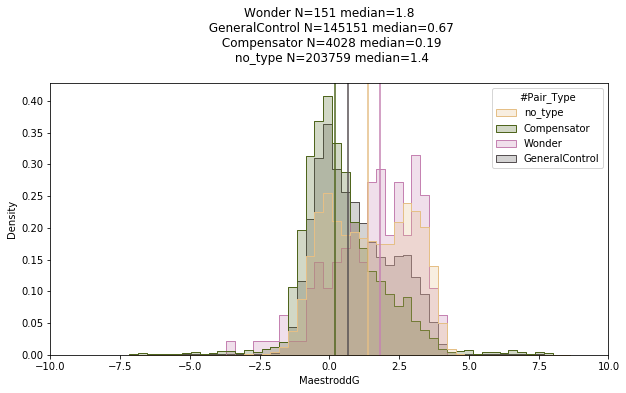

In [166]:
hue_list = ['Wonder',
       'GeneralControl','Compensator','no_type']

plot_hist_bar(hue_list, dfM, '#Pair_Type', 'MaestroddG', 'no',
              (10,5), bins=50,fill=True)
plt.xlim((-10,10))

# FoldX

In [149]:
df1 = df1[df1['FoldXddG']!='?']

In [150]:
df1['FoldXddG'] = df1['FoldXddG'].astype(float)

<module 'matplotlib.pyplot' from '/Users/azbukinanadezda/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

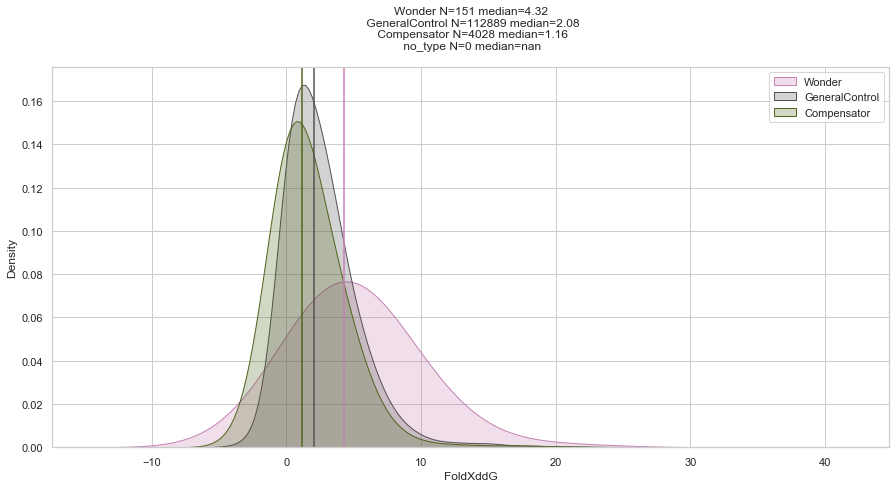

In [151]:
hue_list = ['Wonder', 
       'GeneralControl','Compensator', 'no_type']

plot_hist(hue_list, df1[df1['Effect_A']=='bad'], '#Pair_Type', 'FoldXddG', 'no', (15,7))

In [152]:
df1 = df1.drop_duplicates()

(-20, 40)

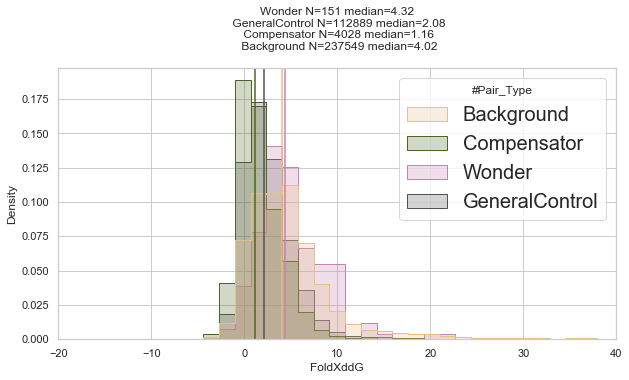

In [107]:
hue_list = ['Wonder',
       'GeneralControl','Compensator','Background']

plot_hist_bar(hue_list, df1[df1['Effect_A']=='bad'], '#Pair_Type', 'FoldXddG', 'no',
              (10,5), bins=50,fill=True)
plt.xlim((-20,40))

(-20, 40)

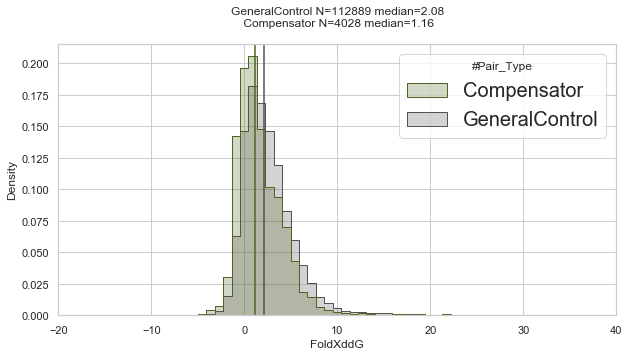

In [106]:
hue_list = [
       'GeneralControl','Compensator']

plot_hist_bar(hue_list, df1[df1['Effect_A']=='bad'], '#Pair_Type', 'FoldXddG', 'no',
              (10,5), bins=50,fill=True)
plt.xlim((-20,40))

In [110]:
df1 = df1[df1['Effect_A']=='bad']

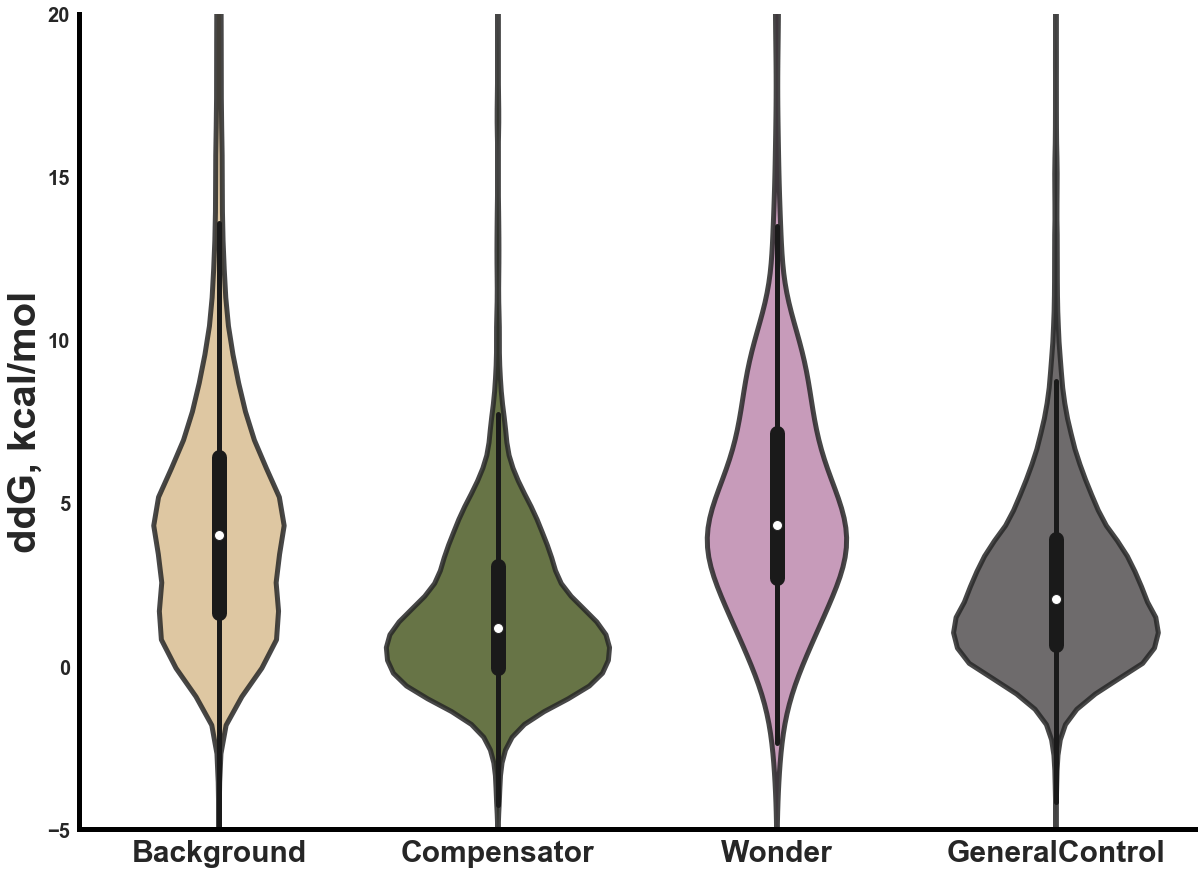

In [113]:

hue_list = ['Wonder',
       'GeneralControl','Compensator','Background']

df1 = df1[df1['#Pair_Type'].isin(hue_list)]



mpl.rcParams['axes.linewidth'] = 5 #задаем толщину линий
width,  height = 20, 15 

sns_plot = sns.violinplot(df1['#Pair_Type'], df1['FoldXddG'],
                         palette = pics.colormap,linewidth=5)

for violin, alpha in zip(sns_plot.collections[::2], [0.85 for i in range(4)]):
    violin.set_alpha(alpha)
#plt.title(fig.axes[0].get_title(), loc='center', pad = 10,
         #size = 20)
    
plt.setp(sns_plot.artists, edgecolor = 'k', facecolor='w') #ставим черный и белые цвета
plt.setp(sns_plot.lines, color='k')

sns.set(rc={"figure.figsize": (width, height)})
sns.set_style("whitegrid")#белый фон
sns_plot.grid(False)#убрать полоски
sns_plot.spines['bottom'].set_color('black')


sns_plot.spines['left'].set_color('black')
   
sns.despine()# убрать рамку

plt.ylabel('ddG, kcal/mol',size = 40, weight='extra bold') 
plt.xlabel('', size=80,  weight='extra bold', labelpad=50)
plt.xticks(size=30, weight='bold', ha="center" )
plt.yticks(size=20, weight='bold', ha="right" )
plt.ylim((-5,20))
fig = sns_plot.get_figure()
fig.savefig(compeletename+ 'Fig3_ddg.png', bbox_inches="tight", dpi = 100)

In [108]:
hue_list = ['Wonder',
       'GeneralControl','Compensator','Background']

In [109]:
for i in range(len(hue_list)):
    for k in range(i+1,len(hue_list)):
        print(hue_list[i],hue_list[k])
        print(calc_U(df1[df1['#Pair_Type']==hue_list[i]]['FoldXddG'], 
                        df1[df1['#Pair_Type']==hue_list[k]]['FoldXddG']))





Wonder GeneralControl
(0.723, 1.98465230157442e-21)
Wonder Compensator
(0.796, 4.7374430958700727e-35)
Wonder Background
(0.549, 0.03902826848614727)
GeneralControl Compensator
(0.604, 4.26231896771872e-112)
GeneralControl Background
(0.66, 0.0)
Compensator Background
(0.738, 0.0)


## FOldX Core

In [25]:
df1['#Pair_Type'].unique()

array(['Background', 'Compensator', 'Wonder', 'ExplicitControl',
       'GeneralControl'], dtype=object)

<module 'matplotlib.pyplot' from '/Users/azbukinanadezda/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

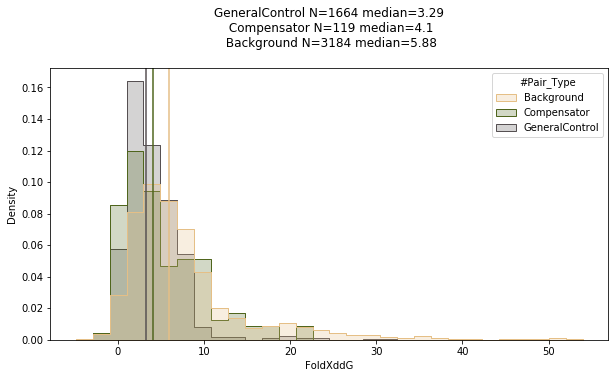

In [28]:
df2 = df1[(df1['Rec_RIN_A'] == 'Core')&(df1['Rec_RIN_C'] == 'Core')]

plot_hist_bar([ 
       'GeneralControl','Compensator', 'Background'], df2, '#Pair_Type', 'FoldXddG', 'no', (10,5),
              30, fill=True)

In [29]:
for i in range(len(hue_list)):
    for k in range(i+1,len(hue_list)):
        print(hue_list[i],hue_list[k])
        print(calc_U(df2[df2['#Pair_Type']==hue_list[i]]['FoldXddG'], 
                        df2[df2['#Pair_Type']==hue_list[k]]['FoldXddG']))





Wonder GeneralControl
(0.645, 0.004363643896311379)
Wonder Compensator
(0.557, 0.31571532034683236)
Wonder Background
(0.557, 0.25683245335654714)
GeneralControl Compensator
(0.558, 0.03526932077721367)
GeneralControl Background
(0.69, 1.8448286904887458e-105)
Compensator Background
(0.611, 3.769540118325439e-05)


In [177]:
df1.columns

Index(['#Pair_Type', 'Dataset', 'Uniprot_AC', 'Pos_A', 'A1', 'A2', 'Pos_C',
       'C1', 'C2', 'Score_A', 'Score_C', 'Score_AC', 'PMD_Phen', 'Effect_A',
       'Effect_C', 'Effect_AC', 'Max_PDB_ID_A', 'Max_Chain_A',
       'Max_Residue-ID_A', 'Max_Residue_AA_type_A', 'Max_Sequence_identity_A',
       'Max_Coverage_A', 'Max_Resolution_A', 'Max_RIN_A',
       'Max_Chain_type_interaction_partners_A',
       'Max_Small_molecules_type_interaction_partners_A', 'Short_Max_RIN_A',
       'Max_Iden_A1 match', 'Max_PDB_ID_C', 'Max_Chain_C', 'Max_Residue-ID_C',
       'Max_Residue_AA_type_C', 'Max_Sequence_identity_C', 'Max_Coverage_C',
       'Max_Resolution_C', 'Max_RIN_C',
       'Max_Chain_type_interaction_partners_C',
       'Max_Small_molecules_type_interaction_partners_C', 'Short_Max_RIN_C',
       'Max_Iden_C1_match', 'Rec_PDB_ID_A', 'Rec_Chain_A', 'Rec_Residue-ID_A',
       'Rec_Residue_AA_type_A', 'Rec_Sequence_identity_A', 'Rec_Coverage_A',
       'Rec_Resolution_A', 'Rec_RIN_A',
     

## FoldX PPI

(-20, 40)

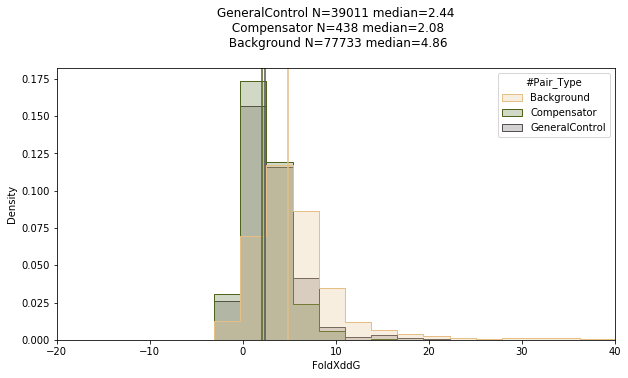

In [30]:
df2 = df1[(df1['Rec_RIN_A'] == 'Protein interaction')&
            (df1['Rec_Chain_type_interaction_partners_C']==df1['Rec_Chain_type_interaction_partners_A'])&
            (df1['Rec_RIN_C'] == 'Protein interaction')]

plot_hist_bar([ 
       'GeneralControl','Compensator', 'Background'], df2, '#Pair_Type', 'FoldXddG', 'no', (10,5),
              30, fill=True)
plt.xlim((-20, 40))

In [31]:
for i in range(len(hue_list)):
    for k in range(i+1,len(hue_list)):
        print(hue_list[i],hue_list[k])
        print(calc_U(df2[df2['#Pair_Type']==hue_list[i]]['FoldXddG'], 
                        df2[df2['#Pair_Type']==hue_list[k]]['FoldXddG']))






Wonder GeneralControl
(0.665, 0.00044246278602100904)
Wonder Compensator
(0.72, 6.923952490620775e-06)
Wonder Background
(0.565, 0.16461141567833293)
GeneralControl Compensator
(0.551, 0.0002414989079377756)
GeneralControl Background
(0.708, 0.0)
Compensator Background
(0.758, 1.9836724677584963e-77)


In [32]:
df[df['#Pair_Type']=='GeneralControl']['Effect_C'].value_counts()

neutral    136836
Name: Effect_C, dtype: int64

## universal

In [220]:
df1['LongA'] = df1['Dataset'] + '_' +df1['Uniprot_AC'] +'_'+df1['Pos_A'].astype(str)
df1['LongC'] = df1['Dataset'] + '_' +df1['Uniprot_AC'] +'_'+df1['Pos_C'].astype(str)

dfcompen = df1[df1['#Pair_Type']=='Compensator'].copy()
dfcompen = dfcompen[dfcompen['Dataset'].str.contains('mave')]
df_degree = dfcompen['LongC'].value_counts()
dfcompen = pd.merge(dfcompen,df_degree, how='left', left_on='LongC', right_index=True)
dfcompen.head()
dfcompen_drop = dfcompen.drop_duplicates(subset='LongC_x')
len(dfcompen_drop)

dflabel = pd.DataFrame(columns=['LongC_x','Universal'])

for elem in dfcompen_drop['Dataset'].unique():
    dflocal = dfcompen_drop[dfcompen_drop['Dataset']==elem]
    tresh = dflocal[['LongC_y']].quantile(.9)
    dflocal['Universal'] = (dflocal['LongC_y'] >= tresh[0]).astype(int)
    print(elem)
    print(len(dflocal))
    print(dflocal['Universal'].value_counts())
    dflabel = dflabel.append(dflocal[['LongC_x','Universal']])
    

dfcompen = pd.merge(dfcompen, dflabel[['LongC_x','Universal']],
                                how='left')


dfcompen = dfcompen[dfcompen.FoldXddG.apply(is_float)] 

dfcompen_short = dfcompen.drop_duplicates(subset=['Uniprot_AC',
                                          'Pos_A','A1', 'A2', 'C1', 'C2',
                                          'Pos_C',
                                          'Dataset'])

maveDB_2
27
0    24
1     3
Name: Universal, dtype: int64
maveDB_4
24
0    21
1     3
Name: Universal, dtype: int64
maveDB_6
32
0    21
1    11
Name: Universal, dtype: int64
maveDB_8
27
0    18
1     9
Name: Universal, dtype: int64
maveDB_13
73
0    65
1     8
Name: Universal, dtype: int64
maveDB_14
11
0    9
1    2
Name: Universal, dtype: int64
maveDB_15
39
0    35
1     4
Name: Universal, dtype: int64
maveDB_17
8
0    7
1    1
Name: Universal, dtype: int64


In [221]:
dflabel['Universal'].value_counts()

0    200
1     41
Name: Universal, dtype: int64

In [222]:
len(dfcompen_drop)

241

In [223]:
len(df_degree)

241

(-5, 10)

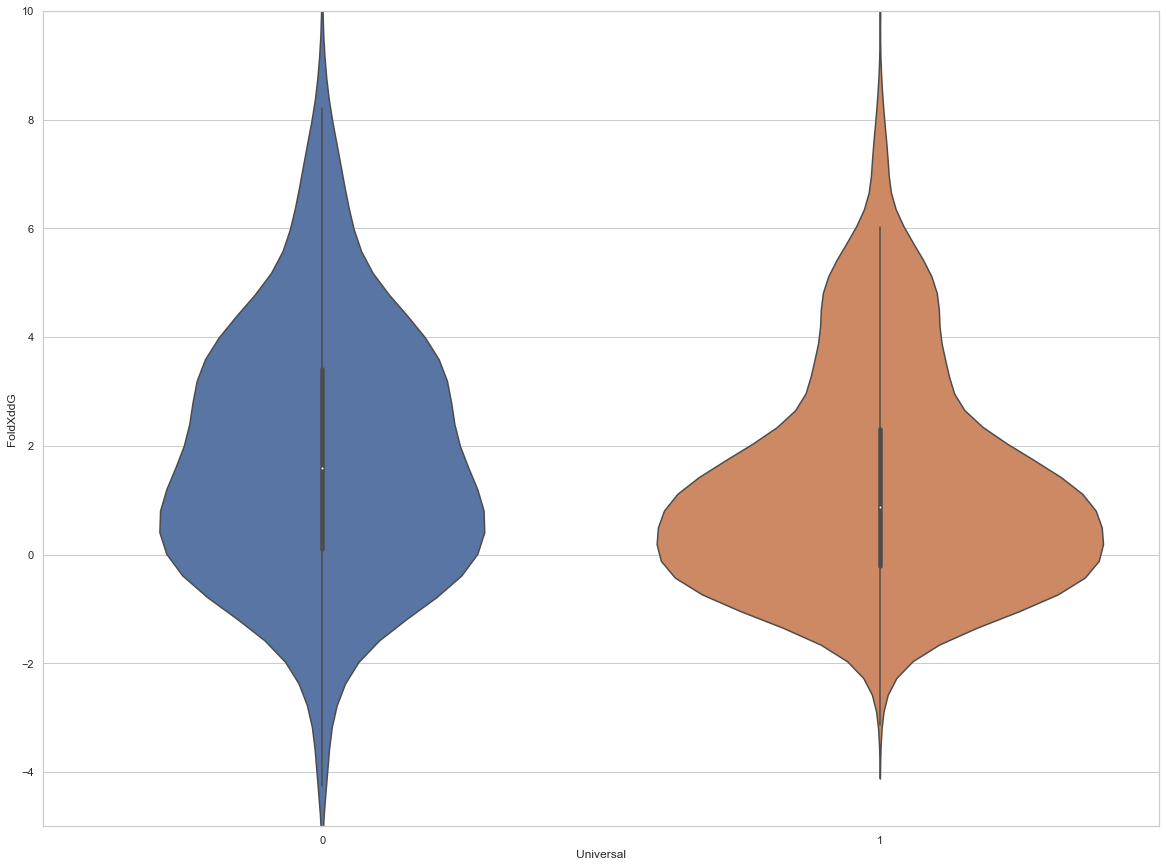

In [224]:
sns.violinplot(x=dfcompen_short['Universal'].astype(str),
               y=dfcompen_short['FoldXddG'].astype(float))
plt.ylim((-5,10))

In [225]:
one = dfcompen_short[dfcompen_short['Universal']==0]['FoldXddG'].astype(float)
two = dfcompen_short[dfcompen_short['Universal']==1]['FoldXddG'].astype(float)
calc_U(one, two)

(0.577, 8.215947296196765e-16)

In [226]:
len(two)

2118

In [227]:
print(np.median(one), np.median(two))

1.5955650000000001 0.874143


# Стабильность в зависимости от расстояния

In [184]:
df = pd.read_csv('../../CPD_data_distance_12_04_21_for_VER.tsv.gz',sep='\t')

for elem in df.columns:
    df = df.rename(columns={elem:elem.replace('.','_')})



In [185]:
len(df[df['Max_Dist_closest']!='?'])

639696

In [157]:
two = pd.read_csv('max.double.ddg.out.tsv',sep='\t')

for elem in two.columns:
    two = two.rename(columns={elem:elem.replace('.','_')})
two.head()   
    

,#ID,PDBId,PDBChain,PDBRes_1,PDBAA1_1,PDBAA2_1,PDBRes_2,PDBAA1_2,PDBAA2_2,MaestroddG,MaestroConf,FoldXddG,BackbHbond,SideHbond,VdW,Electrostatics,SolvationPolar,SolvationHydrophobic,VdWClashes,EntropySide,EntropyMainch,SloopEntropy,MloopEntropy,CisBond,TorsionClash,BackbClash,HelixDipole,WaterBridge,Disulfide,ElectrostKon,PartCovBonds,Ionisation,EntropyComplex
0,Double,1a3s,A,106,A,E,74,K,D,0.389218,0.846785,0.819305,0.0752924,3.55271e-15,0.448895,-0.406529,-0.0936366,0.887289,0.0455788,-0.267404,0.145063,0,0,0,0.03964,0.0903106,-0.0548835,0,0,0,0,-1.11022e-16,0
1,Double,1a3s,A,106,A,I,67,D,T,1.683276,0.828765,-0.155757,-0.295961,-0.292892,-0.605591,0.100645,0.650723,-0.630385,0.0164709,0.46527,0.427732,0,0,0,0.0494638,0.237203,-0.0412324,0,0,0,0,1.11022e-16,0
2,Double,1a3s,A,106,A,T,78,E,G,1.027869,0.878053,1.45292,0.0611851,1.77636e-15,0.627621,0.340886,-0.611756,0.907461,3.18385e-05,-0.741944,0.896824,0,0,0,-0.0273903,-0.109621,-1.11022e-16,0,0,0,0,0,0
3,Double,1a3s,A,106,A,T,40,N,D,0.815393,0.833518,-0.587619,-0.0746799,-0.00492086,-0.0267913,-1.2309,1.12926,-0.0185775,-0.670529,0.210822,0.101728,0,0,0,-0.00302911,0.104204,3.35287e-14,0,0,0,0,1.11022e-16,0
4,Double,1a3s,A,26,A,G,106,A,T,1.056135,0.865765,2.00284,0.057855,1.77636e-15,0.637581,-0.00127952,-0.141191,1.26461,-0.114521,-0.0153555,0.382413,0,0,0,-0.0672707,-0.0354178,0,0,0,0,0,0,0


In [158]:
two = two[['PDBId', 'PDBChain', 'PDBRes_1', 'PDBAA1_1', 'PDBAA2_1',
       'PDBRes_2', 'PDBAA1_2', 'PDBAA2_2', 'MaestroddG', 'MaestroConf',
       'FoldXddG', ]]

In [159]:
two['PDBRes_1'] = two['PDBRes_1'].astype(str)
two['PDBRes_2'] = two['PDBRes_2'].astype(str)

In [186]:
df = df[(df['Max_PDB_ID_A']==df['Max_PDB_ID_C'])&(df['Max_PDB_ID_A']!='?')]
df = df[(df['Max_Chain_A']==df['Max_Chain_C'])]
df['Max_Residue-ID_A'] = df['Max_Residue-ID_A'].astype(str)
df['Max_Residue-ID_C'] = df['Max_Residue-ID_C'].astype(str)
#df = df[(df['Max_Iden_A1 match']==1)&(df['Max_Iden_C1_match']==1)]

In [187]:

df=df.reset_index(drop=True)
df1 = pd.merge(df, two, left_on = ['A1', 'A2', 'C1', 
                                   'C2','Max_PDB_ID_A', 'Max_Chain_A', 'Max_Residue-ID_A',
                            'Max_Residue-ID_C',],
        right_on =['PDBAA1_1', 'PDBAA2_1','PDBAA1_2', 'PDBAA2_2',
                 'PDBId','PDBChain', 'PDBRes_1','PDBRes_2',],how='left' )
df1 = df1.dropna()
len(df1)

576197

In [188]:
df1 = df1.drop_duplicates(subset=['#Pair_Type', 'Dataset', 'Uniprot_AC', 'Pos_A','Pos_C',
                                 'A1','A2', 'C1', 'C2','Max_PDB_ID_A'], 
                     keep = 'first')
len(df1)

563093

In [189]:
df1 = df1[df1['FoldXddG']!='?']

df1 = df1[df1['Max_Dist_closest']!='?']
print(len(df1))
df1['FoldXddG'] = df1['FoldXddG'].astype(float)
df1['Max_Dist_closest'] = df1['Max_Dist_closest'].astype(float)

543375


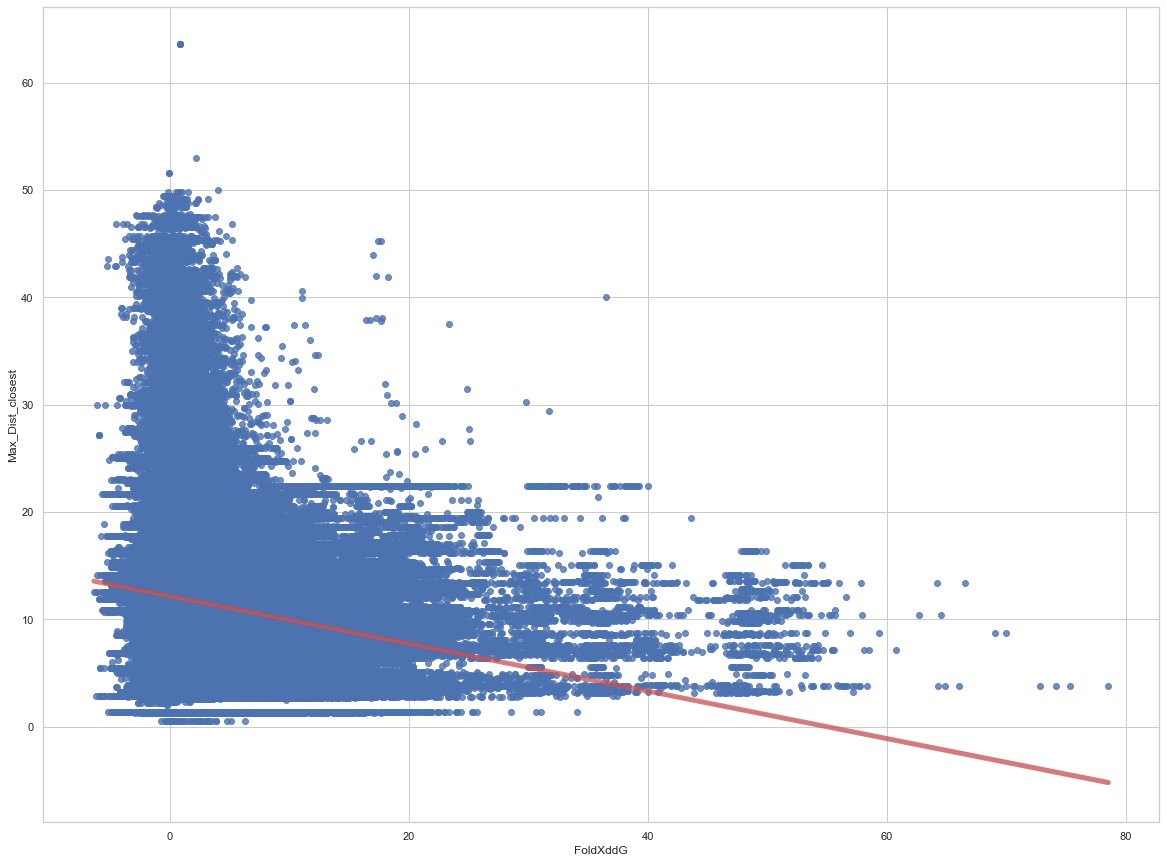

In [190]:
sns.regplot(x=df1['FoldXddG'], y=df1['Max_Dist_closest'], 
            line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

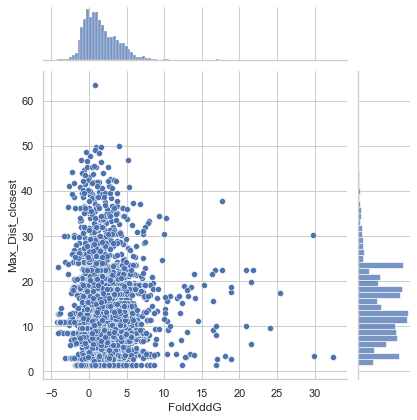

In [194]:
df2 = df1[df1['#Pair_Type']=='Compensator']

sns.jointplot(x=df2['FoldXddG'], y=df2['Max_Dist_closest'], 
            )
plt.show()

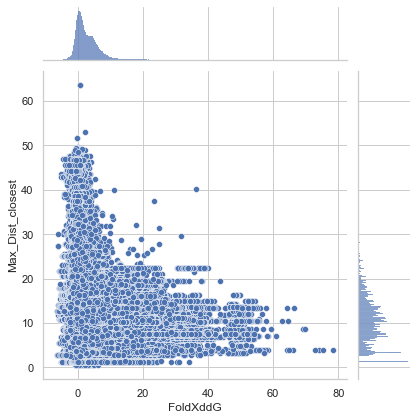

In [195]:
df2 = df1[df1['#Pair_Type']=='Background']

sns.jointplot(x=df2['FoldXddG'], y=df2['Max_Dist_closest'], 
            )
plt.show()

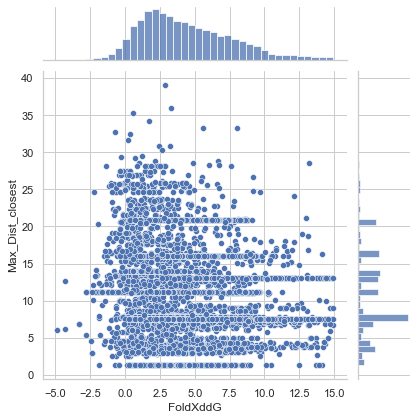

In [197]:
df2 = df1[(df1['Rec_RIN_A']=='Core')&(df1['Rec_RIN_C']=='Core')]
df2 = df2[df2['FoldXddG']<15]
sns.jointplot(x=df2['FoldXddG'], y=df2['Max_Dist_closest'], 
            )
plt.show()

# single mutations

In [114]:
one = pd.read_csv('max.single.ddg.out.tsv',sep='\t')

for elem in one.columns:
    one = one.rename(columns={elem:elem.replace('.','_')})
one.head()   
    

,#ID,PDBId,PDBChain,PDBRes,PDBAA1,PDBAA2,MaestroddG,MaestroConf,FoldXddG,BackbHbond,SideHbond,VdW,Electrostatics,SolvationPolar,SolvationHydrophobic,VdWClashes,EntropySide,EntropyMainch,SloopEntropy,MloopEntropy,CisBond,TorsionClash,BackbClash,HelixDipole,WaterBridge,Disulfide,ElectrostKon,PartCovBonds,Ionisation,EntropyComplex
0,Single,13gs,A,148,I,G,2.124067,0.791479,2.99621,0.00968068,0.290638,2.62272,0.173699,-2.39739,4.05534,-0.200064,-1.14394,-0.369328,0,0,0,-0.0353785,-0.237195,-0.00976867,0,0,-8.54872e-15,0,6.66134e-16,0
1,Single,13gs,A,153,Y,A,1.375213,0.846702,5.62658,0.604708,2.22595,2.65505,0.401714,-2.02547,3.96447,0.0202681,-1.7943,-0.416242,0,0,0,0.0144415,-0.701303,-0.0240097,0,0,-9.32587e-15,0,4.44089e-16,0
2,Single,13gs,A,153,Y,F,0.107138,0.909106,0.831364,0.00509932,2.30358,0.143674,-0.12795,-0.733109,-0.307277,0.02287,-0.534482,0.0136714,0,0,0,0.0554778,-0.117048,-0.0101947,0,0,-9.32587e-15,0,4.44089e-16,0
3,Single,13gs,B,148,I,G,2.124067,0.791479,3.07139,0.00465344,0.105066,2.40046,0.191207,-2.04034,3.86526,-0.0904491,-1.12965,-0.215597,0,0,0,-0.0304357,-0.221186,0.0112142,0,0,-9.10383e-15,0,6.66134e-16,0
4,Single,13gs,B,153,Y,A,1.375213,0.846702,5.32796,0.0697591,0.772664,2.64922,0.649627,-2.41978,3.90897,-0.0699812,-0.952735,-0.332265,0,0,0,1.0064,-0.515816,0.0460836,0,0,-8.54872e-15,0,8.88178e-16,0


In [115]:
df = pd.read_csv('../../CPD_data_12_04_21_for_VER_ddG.tsv.gz',sep='\t')

for elem in df.columns:
    df = df.rename(columns={elem:elem.replace('.','_')})

df = df[(df['Max_PDB_ID_A']==df['Max_PDB_ID_C'])&(df['Max_PDB_ID_A']!='?')]
df = df[(df['Max_Chain_A']==df['Max_Chain_C'])]
df['Max_Residue-ID_A'] = df['Max_Residue-ID_A'].astype(str)
df['Max_Residue-ID_C'] = df['Max_Residue-ID_C'].astype(str)
#df = df[(df['Max_Iden_A1 match']==1)&(df['Max_Iden_C1_match']==1)]

df = df.drop_duplicates(subset=['#Pair_Type', 'Dataset', 'Uniprot_AC', 'Pos_A','Pos_C',
                                 'A1','A2', 'C1', 'C2','Max_PDB_ID_A'], 
                     keep = 'first')


df.reset_index(inplace=True, drop=True)
len(df)

624070

In [116]:
one = one[['PDBId', 'PDBChain', 'PDBRes', 'PDBAA1', 'PDBAA2',
       'MaestroddG', 
       'FoldXddG', ]]

one['PDBRes'] = one['PDBRes'].astype(str)


In [117]:
df1 = pd.merge(df, one, left_on = ['A1', 'A2', 'Max_PDB_ID_A',
                                   'Max_Chain_A', 'Max_Residue-ID_A',
                            ],
        right_on =['PDBAA1', 'PDBAA2',
                 'PDBId','PDBChain', 'PDBRes'],how='left' )
df1 = df1.dropna()
len(df1)

600999

In [118]:
df1.columns

Index(['#Pair_Type', 'Dataset', 'Uniprot_AC', 'Pos_A', 'A1', 'A2', 'Pos_C',
       'C1', 'C2', 'Score_A', 'Score_C', 'Score_AC', 'PMD_Phen', 'Effect_A',
       'Effect_C', 'Effect_AC', 'Max_PDB_ID_A', 'Max_Chain_A',
       'Max_Residue-ID_A', 'Max_Residue_AA_type_A', 'Max_Sequence_identity_A',
       'Max_Coverage_A', 'Max_Resolution_A', 'Max_RIN_A',
       'Max_Chain_type_interaction_partners_A',
       'Max_Small_molecules_type_interaction_partners_A', 'Short_Max_RIN_A',
       'Max_Iden_A1 match', 'Max_PDB_ID_C', 'Max_Chain_C', 'Max_Residue-ID_C',
       'Max_Residue_AA_type_C', 'Max_Sequence_identity_C', 'Max_Coverage_C',
       'Max_Resolution_C', 'Max_RIN_C',
       'Max_Chain_type_interaction_partners_C',
       'Max_Small_molecules_type_interaction_partners_C', 'Short_Max_RIN_C',
       'Max_Iden_C1_match', 'Rec_PDB_ID_A', 'Rec_Chain_A', 'Rec_Residue-ID_A',
       'Rec_Residue_AA_type_A', 'Rec_Sequence_identity_A', 'Rec_Coverage_A',
       'Rec_Resolution_A', 'Rec_RIN_A',
     

In [119]:
df1 = df1.rename(columns={
       'MaestroddG':'MaestroddG_A', 'FoldXddG':'FoldXddG_A'  
})
df1 = df1.drop(['PDBId', 'PDBChain', 'PDBRes', 'PDBAA1', 'PDBAA2',], axis=1)

In [120]:
df1 = pd.merge(df1, one, left_on = ['C1', 'C2', 'Max_PDB_ID_A', 'Max_Chain_A', 'Max_Residue-ID_C',
                            ],
        right_on =['PDBAA1', 'PDBAA2',
                 'PDBId','PDBChain', 'PDBRes'],how='left' )
df1 = df1.dropna()
len(df1)

584833

In [121]:
df1 = df1.rename(columns={
       'MaestroddG':'MaestroddG_C', 'FoldXddG':'FoldXddG_C'  
})
df1 = df1.drop(['PDBId', 'PDBChain', 'PDBRes', 'PDBAA1', 'PDBAA2',], axis=1)

## bad compensated and not

In [122]:
df2 = df1[df1.Effect_A=='bad']
df2 = df2.sort_values(by = '#Pair_Type')
dfcom = df2[df2['#Pair_Type']=='Compensator'].copy()
df2 = df2[df2['#Pair_Type']!='Compensator']
df2 = df2.drop_duplicates(subset=['Dataset','Pos_A', 'A1', 'A2','Uniprot_AC',], 
                          keep = 'first')

df2 = df2.append(dfcom)

df2 = df2.drop_duplicates(subset=['Dataset','Pos_A', 'A1', 'A2','Uniprot_AC',], 
                          keep = 'last')

df2['#Pair_Type'] = df2['#Pair_Type'].apply(rename_bad)
df2 = df2[df2['FoldXddG_A']!='?']
df2['FoldXddG_A'] = df2['FoldXddG_A'].astype(float)




In [123]:
import pylab as plot
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plot.rcParams.update(params)

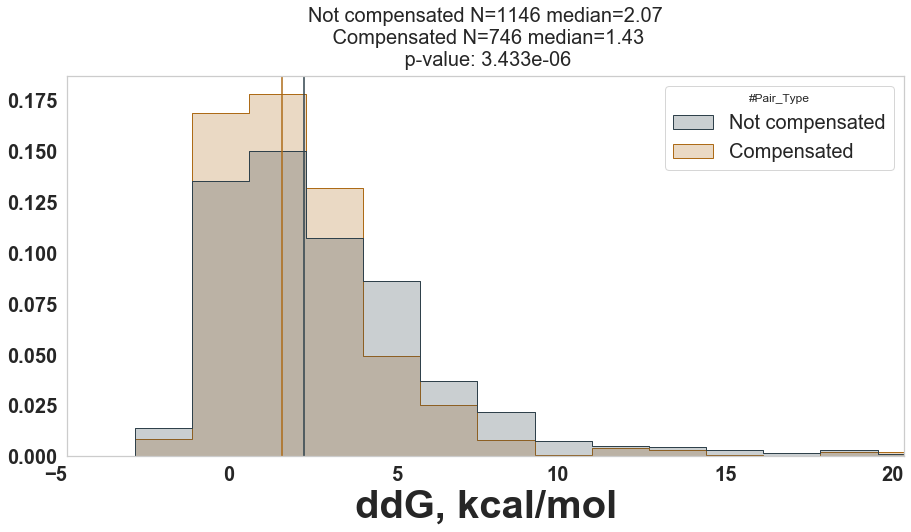

In [124]:
hue_list = ['Not compensated','Compensated']
fig = pics.plot_hist_bar(hue_list,df2, '#Pair_Type', 'FoldXddG_A', 'mann', (15,7),bins=30,fill=True)
#fig.xlabel('Bad compensated and not. FoldXddG')
plt.xlim((-5,20))

plt.grid(b=None)
plt.title(fig.axes[0].get_title(), loc='center', pad = 10,
         size = 20)
plt.xlabel('ddG, kcal/mol',size = 40, weight='extra bold') 
plt.ylabel('', size=80,  weight='extra bold', labelpad=50)
plt.xticks(size=20, weight='bold', ha="right" )
plt.yticks(size=20, weight='bold', ha="right" )

fig.savefig(compeletename+ 'Fig_3_bad.png', bbox_inches="tight", dpi = 100)

In [125]:
pics.calc_U(df2[df2['#Pair_Type']=='Not compensated']['FoldXddG_A'],
            df2[df2['#Pair_Type']=='Compensated']['FoldXddG_A'] )

(0.563, 3.433010962629584e-06)

In [126]:
df2 = df1[df1.Effect_C=='neutral']

df2 = df2.sort_values(by = '#Pair_Type')
dfcom = df2[df2['#Pair_Type']=='Compensator'].copy()
df2 = df2[df2['#Pair_Type']!='Compensator']
df2 = df2.drop_duplicates(subset=['Dataset','Pos_C', 'C1', 'C2','Uniprot_AC',], 
                          keep = 'first')

df2 = df2.append(dfcom)
df2 = df2.drop_duplicates(subset=['Dataset','Pos_C', 'C1', 'C2','Uniprot_AC',], 
                          keep = 'last')
#df2 = df2.drop_duplicates(subset=['Dataset','Pos_A', 'A1', 'A2','Uniprot_AC',], 
                          #keep = 'last')

df2 = df2[df2['#Pair_Type']!='Wonder']


df2['#Pair_Type'] = df2['#Pair_Type'].apply(rename_neutral)
df2 = df2[df2['FoldXddG_C']!='?']
df2['FoldXddG_C'] = df2['FoldXddG_C'].astype(float)




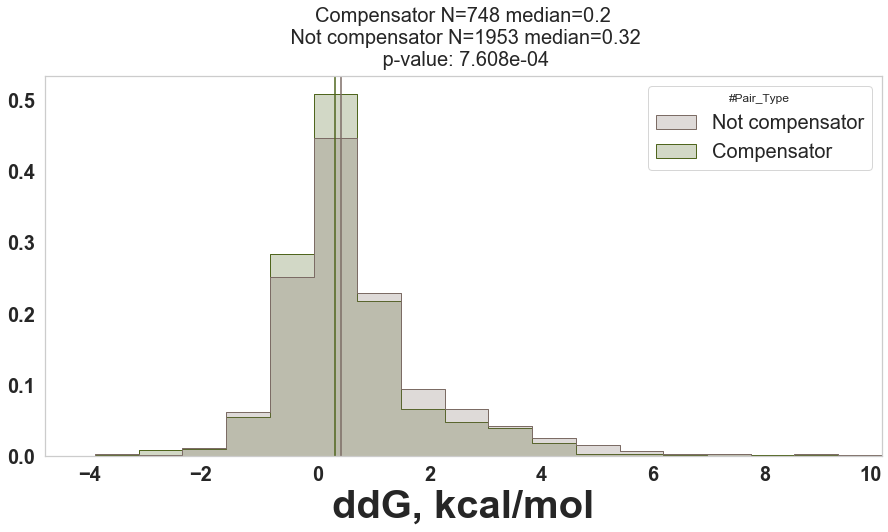

In [127]:
hue_list = ['Compensator','Not compensator']
fig = pics.plot_hist_bar(hue_list,df2, '#Pair_Type', 'FoldXddG_C', 'mann', (15,7),bins=30,fill=True)

plt.xlim((-5,10))
plt.grid(b=None)

plt.title(fig.axes[0].get_title(), loc='center', pad = 10,
         size = 20)
plt.xlabel('ddG, kcal/mol',size = 40, weight='extra bold') 
plt.ylabel('', size=80,  weight='extra bold', labelpad=50)
plt.xticks(size=20, weight='bold', ha="right" )
plt.yticks(size=20, weight='bold', ha="right" )

fig.savefig(compeletename+ 'Fig_3_neutral.png', bbox_inches="tight", dpi = 100)

In [128]:
pics.calc_U(df2[df2['#Pair_Type']=='Not compensator']['FoldXddG_C'],
            df2[df2['#Pair_Type']=='Compensator']['FoldXddG_C'] )

(0.542, 0.0007607678045526043)

## depends on RIN. Core


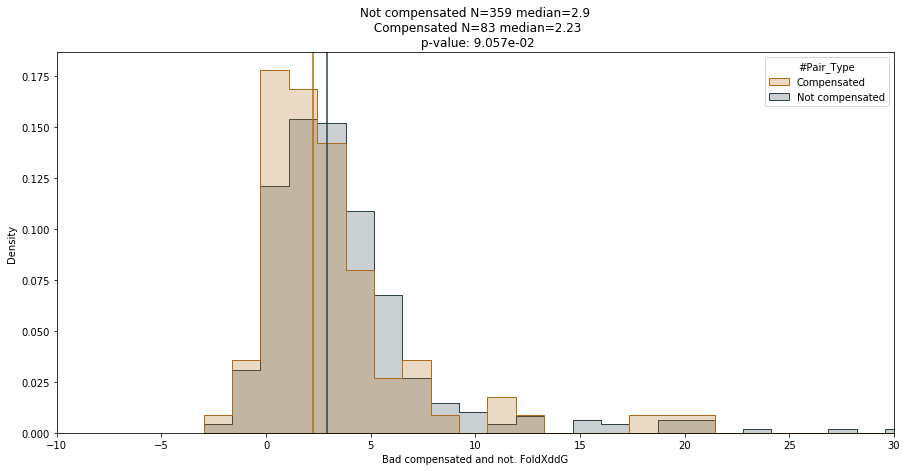

In [209]:
df2 = df1[(df1['Rec_RIN_A'] == 'Core')&(df1['Rec_RIN_C'] == 'Core')]
df2 = df2[df2.Effect_A=='bad']
df2 = df2.sort_values(by = '#Pair_Type')
df2 = df2.drop_duplicates(subset=['Dataset','Pos_A', 'A1', 'A2','Uniprot_AC',], 
                          keep = 'first')
df2 = df2[df2['#Pair_Type']!='Wonder']
df2['#Pair_Type'] = df2['#Pair_Type'].apply(rename_bad)
df2 = df2[df2['FoldXddG_A']!='?']
df2['FoldXddG_A'] = df2['FoldXddG_A'].astype(float)


hue_list = ['Not compensated','Compensated']
fig = plot_hist_bar(hue_list,df2, '#Pair_Type', 'FoldXddG_A', 'mann', (15,7),bins=30,fill=True)
fig.xlabel('Bad compensated and not. FoldXddG')
fig.xlim((-10,30))
fig.show()



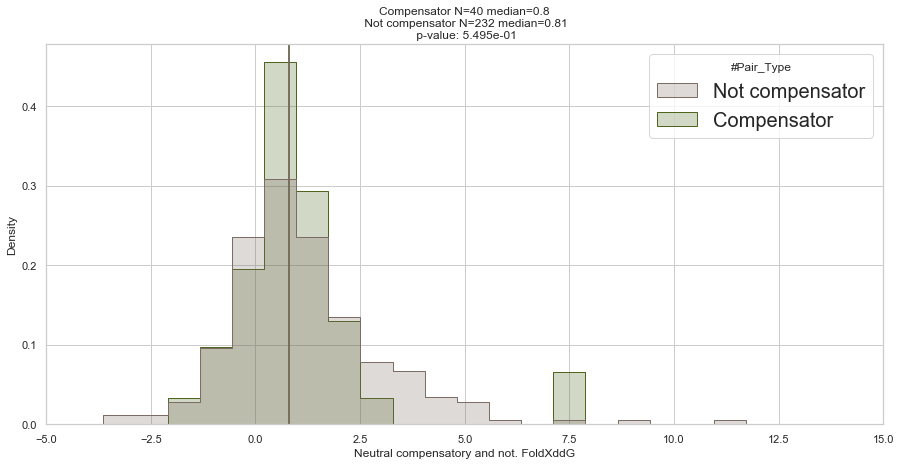

In [84]:
df2 = df1[(df1['Rec_RIN_A'] == 'Core')&(df1['Rec_RIN_C'] == 'Core')]
df2 = df2[df2.Effect_C=='neutral']

df2 = df2.sort_values(by = '#Pair_Type')
dfcom = df2[df2['#Pair_Type']=='Compensator'].copy()
df2 = df2[df2['#Pair_Type']!='Compensator']
df2 = df2.drop_duplicates(subset=['Dataset','Pos_C', 'C1', 'C2','Uniprot_AC',], 
                          keep = 'first')

df2 = df2.append(dfcom)

df2 = df2.drop_duplicates(subset=['Dataset','Pos_C', 'C1', 'C2','Uniprot_AC',], 
                          keep = 'last')
df2['#Pair_Type'] = df2['#Pair_Type'].apply(rename_neutral)
df2 = df2[df2['FoldXddG_C']!='?']
df2['FoldXddG_C'] = df2['FoldXddG_C'].astype(float)


hue_list = ['Compensator','Not compensator']
fig = plot_hist_bar(hue_list,df2, '#Pair_Type', 'FoldXddG_C', 'mann', (15,7),bins=30,fill=True)
fig.xlabel('Neutral compensatory and not. FoldXddG')
fig.xlim((-5,15))
fig.show()


## PPI

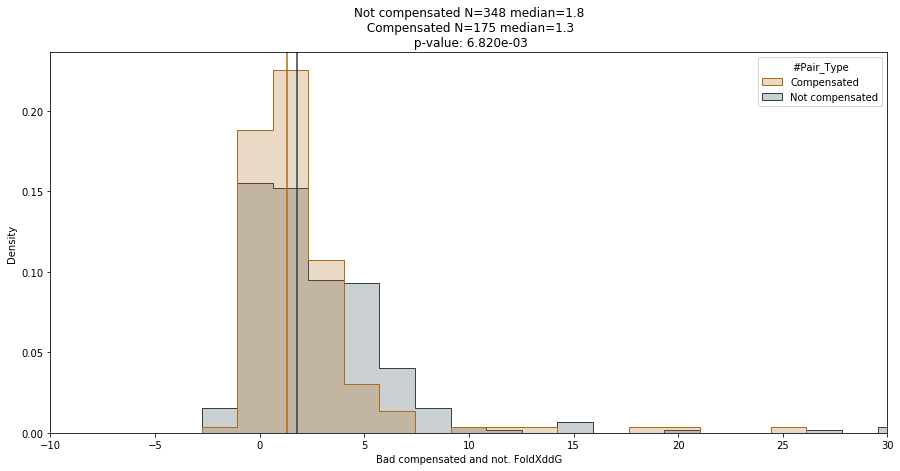

In [211]:
df2 = df1[(df1['Rec_RIN_A'] == 'Protein interaction')&
            (df1['Rec_Chain_type_interaction_partners_C']==df1['Rec_Chain_type_interaction_partners_A'])&
            (df1['Rec_RIN_C'] == 'Protein interaction')]
df2 = df2[df2.Effect_A=='bad']
df2 = df2.sort_values(by = '#Pair_Type')
df2 = df2.drop_duplicates(subset=['Dataset','Pos_A', 'A1', 'A2','Uniprot_AC',], 
                          keep = 'first')
df2 = df2[df2['#Pair_Type']!='Wonder']
df2['#Pair_Type'] = df2['#Pair_Type'].apply(rename_bad)
df2 = df2[df2['FoldXddG_A']!='?']
df2['FoldXddG_A'] = df2['FoldXddG_A'].astype(float)


hue_list = ['Not compensated','Compensated']
fig = plot_hist_bar(hue_list,df2, '#Pair_Type', 'FoldXddG_A', 'mann', (15,7),bins=30,fill=True)
fig.xlabel('Bad compensated and not. FoldXddG')
fig.xlim((-10,30))
fig.show()




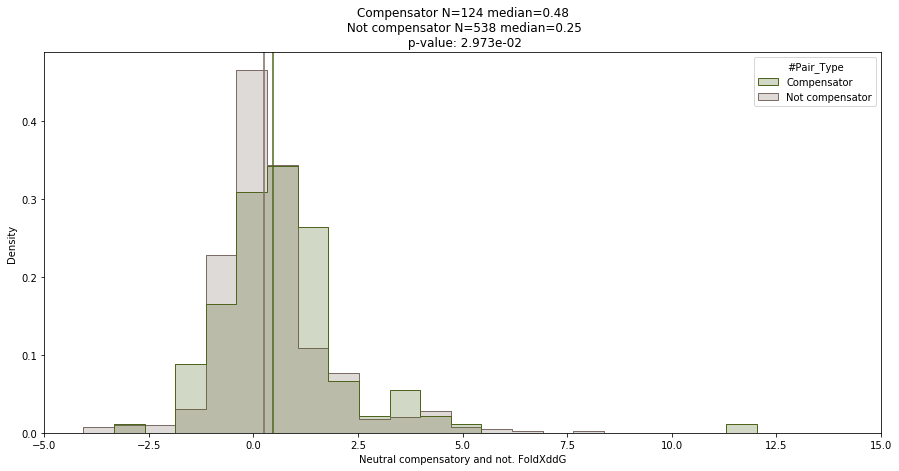

In [212]:
df2 = df1[(df1['Rec_RIN_A'] == 'Protein interaction')&
            (df1['Rec_Chain_type_interaction_partners_C']==df1['Rec_Chain_type_interaction_partners_A'])&
            (df1['Rec_RIN_C'] == 'Protein interaction')]
df2 = df2[df2.Effect_C=='neutral']
df2 = df2.sort_values(by = '#Pair_Type')
df2 = df2.drop_duplicates(subset=['Dataset','Pos_C', 'C1', 'C2','Uniprot_AC',], 
                          keep = 'first')
df2 = df2[df2['#Pair_Type']!='Wonder']
df2['#Pair_Type'] = df2['#Pair_Type'].apply(rename_neutral)
df2 = df2[df2['FoldXddG_C']!='?']
df2['FoldXddG_C'] = df2['FoldXddG_C'].astype(float)


hue_list = ['Compensator','Not compensator']
fig = plot_hist_bar(hue_list,df2, '#Pair_Type', 'FoldXddG_C', 'mann', (15,7),bins=30,fill=True)
fig.xlabel('Neutral compensatory and not. FoldXddG')
fig.xlim((-5,15))
fig.show()



## general bad distibution depends on RIN

In [129]:
df2 = df1[df1.Effect_A=='bad']
df2 = df2.sort_values(by = '#Pair_Type')
df2 = df2.drop_duplicates(subset=['Dataset','Pos_A', 'A1', 'A2','Uniprot_AC',], 
                          keep = 'first')
df2 = df2[df2['#Pair_Type']!='Wonder']

df2 = df2[df2['FoldXddG_A']!='?']
df2['FoldXddG_A'] = df2['FoldXddG_A'].astype(float)
df2 = df2[df2['Rec_RIN_A']!='?']




In [130]:
import matplotlib as mpl

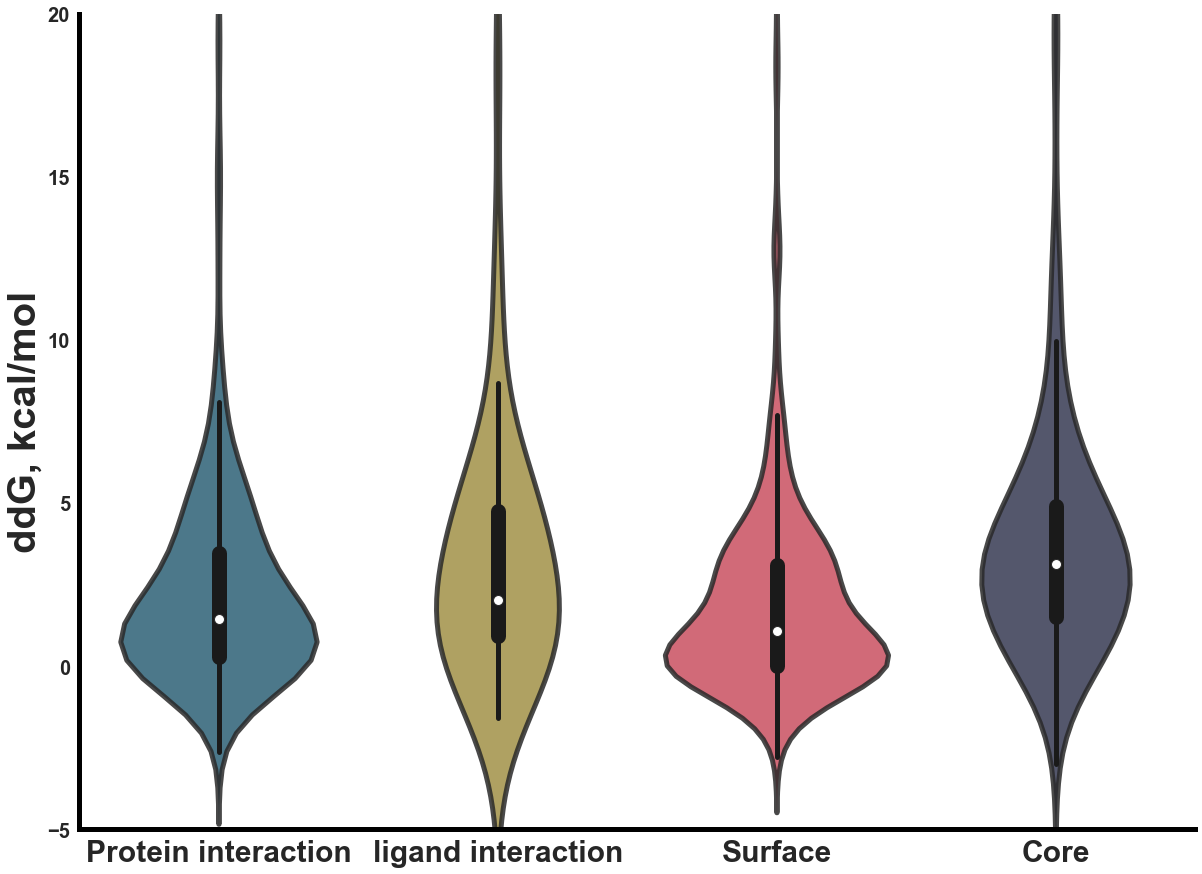

In [131]:

hue_list = ['Surface', 'Core',         
           'Protein interaction', 
           'ligand interaction']

df2 = df2[df2['Rec_RIN_A'].isin(hue_list)]


mpl.rcParams['axes.linewidth'] = 5 #задаем толщину линий
width,  height = 20, 15 

sns_plot = sns.violinplot(df2['Rec_RIN_A'], df2['FoldXddG_A'],
                         palette = pics.colormap,linewidth=5)

for violin, alpha in zip(sns_plot.collections[::2], [0.85 for i in range(4)]):
    violin.set_alpha(alpha)
#plt.title(fig.axes[0].get_title(), loc='center', pad = 10,
         #size = 20)
    
plt.setp(sns_plot.artists, edgecolor = 'k', facecolor='w') #ставим черный и белые цвета
plt.setp(sns_plot.lines, color='k')

sns.set(rc={"figure.figsize": (width, height)})
sns.set_style("whitegrid")#белый фон
sns_plot.grid(False)#убрать полоски
sns_plot.spines['bottom'].set_color('black')


sns_plot.spines['left'].set_color('black')
   
sns.despine()# убрать рамку

plt.ylabel('ddG, kcal/mol',size = 40, weight='extra bold') 
plt.xlabel('', size=80,  weight='extra bold', labelpad=50)
plt.xticks(size=30, weight='bold', ha="center" )
plt.yticks(size=20, weight='bold', ha="right" )
plt.ylim((-5,20))
fig = sns_plot.get_figure()
fig.savefig(compeletename+ 'Fig3_rins.png', bbox_inches="tight", dpi = 100)

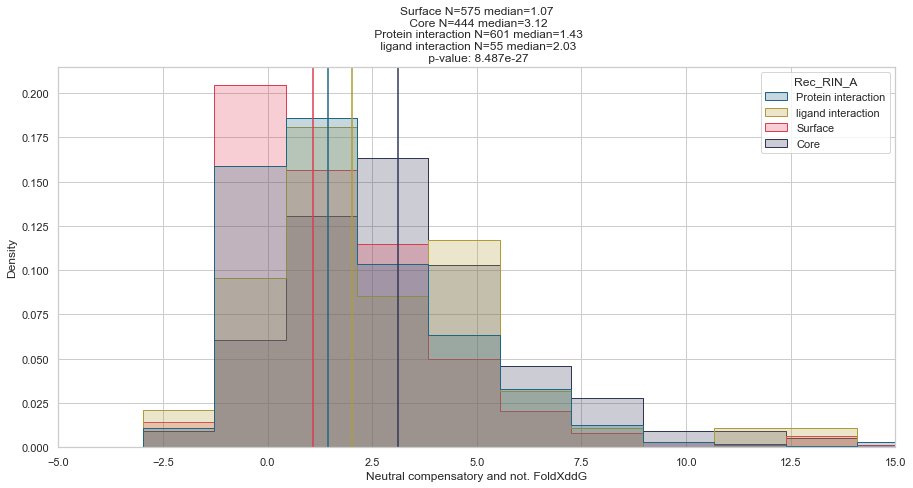

In [43]:
fig = pics.plot_hist_bar(hue_list,df2, 'Rec_RIN_A', 'FoldXddG_A', 'mann', 
                         (15,7),bins=30,fill=True)
plt.xlabel('Bad compensatory and not. FoldXddG')
plt.xlim((-5,15))
fig.show()




In [51]:
df2 = df1[df1.Effect_C=='neutral']

df2 = df2.sort_values(by = '#Pair_Type')
dfcom = df2[df2['#Pair_Type']=='Compensator'].copy()
df2 = df2[df2['#Pair_Type']!='Compensator']
df2 = df2.drop_duplicates(subset=['Dataset','Pos_A', 'A1', 'A2','Uniprot_AC',], 
                          keep = 'first')

df2 = df2.append(dfcom)

#df2 = df2.drop_duplicates(subset=['Dataset','Pos_A', 'A1', 'A2','Uniprot_AC',], 
                          #keep = 'last')

df2 = df2[df2['#Pair_Type']!='Wonder']


df2['#Pair_Type'] = df2['#Pair_Type'].apply(rename_neutral)
df2 = df2[df2['FoldXddG_C']!='?']
df2['FoldXddG_C'] = df2['FoldXddG_C'].astype(float)

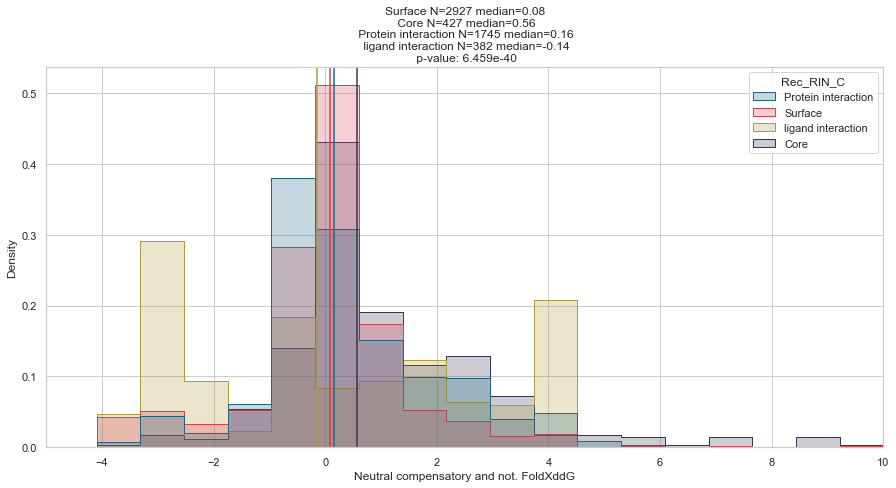

In [53]:
fig = pics.plot_hist_bar(hue_list,df2, 'Rec_RIN_C', 'FoldXddG_C', 'mann', 
                         (15,7),bins=30,fill=True)
plt.xlabel('Neutral compensatory and not. FoldXddG')
plt.xlim((-5,10))
fig.show()





## universal and not

In [53]:
df1['LongA'] = df1['Dataset'] + '_' +df1['Uniprot_AC'] +'_'+df1['Pos_A'].astype(str)
df1['LongC'] = df1['Dataset'] + '_' +df1['Uniprot_AC'] +'_'+df1['Pos_C'].astype(str)

dfcompen = df1[df1['#Pair_Type']=='Compensator'].copy()
df_degree = dfcompen['LongC'].value_counts()
dfcompen = pd.merge(dfcompen,df_degree, how='left', left_on='LongC', right_index=True)
dfcompen.head()
dfcompen_drop = dfcompen.drop_duplicates(subset='LongC_x')
len(dfcompen_drop)

403

In [54]:
dflabel = pd.DataFrame(columns=['LongC_x','Universal'])

for elem in dfcompen_drop['Dataset'].unique():
    dflocal = dfcompen_drop[dfcompen_drop['Dataset']==elem]
    tresh = dflocal[['LongC_y']].quantile(.9)
    dflocal['Universal'] = (dflocal['LongC_y'] >= tresh[0]).astype(int)
    dflabel = dflabel.append(dflocal[['LongC_x','Universal']])
    



In [55]:
dfcompen = pd.merge(dfcompen, dflabel[['LongC_x','Universal']],
                                how='left')



In [56]:
dfcompen['Universal'].value_counts()

1    2970
0    1791
Name: Universal, dtype: int64

In [57]:
dfcompen = dfcompen[dfcompen.FoldXddG_C.apply(is_float)] 

In [58]:
dfcompen_short = dfcompen.drop_duplicates(subset=['Uniprot_AC',
                                          'Pos_A','A1', 'A2', 'C1', 'C2',
                                          'Pos_C',
                                          'Dataset'])

(-5, 10)

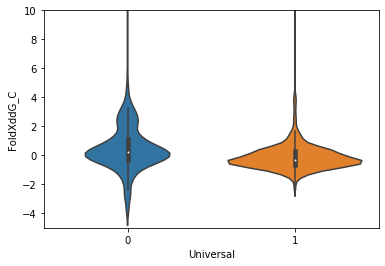

In [59]:
sns.violinplot(x=dfcompen_short['Universal'].astype(str),
               y=dfcompen_short['FoldXddG_C'].astype(float))
plt.ylim((-5,10))

In [60]:
one = dfcompen_short[dfcompen_short['Universal']==0]['FoldXddG_C'].astype(float)
two = dfcompen_short[dfcompen_short['Universal']==1]['FoldXddG_C'].astype(float)
calc_U(one, two)

(0.656, 2.265699221964365e-66)

In [61]:
np.median(one)

0.216544

In [62]:
np.median(two)

-0.329039

(-5, 10)

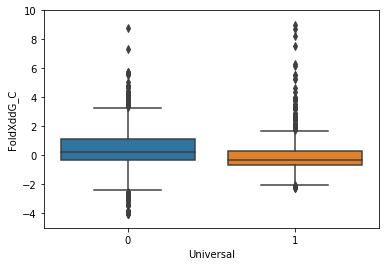

In [283]:
sns.boxplot(x=dfcompen_short['Universal'].astype(str),
            
               y=dfcompen_short['FoldXddG_C'].astype(float))
plt.ylim((-5,10))